#### TOC
1. Anomalies in Data, and cleaning action & explaination. 15 pts
2. Pairwise Corralation Table and explaition. 10 pts
3. Average records stockID vs Day, 25 pts
    - a. autocorrelation, 10 pts
    - b. measure the distance, 5 pts
    - c. clustering algorithm, 10 pts
4. Closing trajectory of stocks on each day highly correlated, 25 pts
   - a. Make three plots, 10 pts
   - b. permutation test to determine the statistical confidence, 15 pts
      p-value
5. Best prediction model, any approaches, 25 pts
6. submit model on Kaggle, 0 pts

#### Start
- Copy this notebook.
  In Google Colab use `File -> Save a Copy in Drive`.
- Use the "Text" blocks to provide explanations wherever you find them necessary.
- Highlight your answers inside these text fields to ensure that we don't miss it
while grading your HW.

#### Setup

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and
uploading it to your drive), you can skip this section.

In [1]:
## packages
!pip install -q kaggle
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q numpy
!pip install -q Matplotlib
!pip install -q seaborn
!pip install -q missingno
!pip install -q statsmodels
!pip install -q tensorflow

In [2]:
## Upload the file by clicking on the browse
from google.colab import files
files.upload()

## Create a new API token under "Account" in the kaggle webpage and download the json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bindubhargavachintam","key":"a9e63e935092925d10aa9244afc6a748"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c optiver-trading-at-the-close
!unzip optiver-trading-at-the-close.zip
!ls

100% 201M/201M [00:00<00:00, 268MB/s]
100% 201M/201M [00:00<00:00, 246MB/s]
Archive:  optiver-trading-at-the-close.zip
  inflating: example_test_files/revealed_targets.csv  
  inflating: example_test_files/sample_submission.csv  
  inflating: example_test_files/test.csv  
  inflating: optiver2023/__init__.py  
  inflating: optiver2023/competition.cpython-310-x86_64-linux-gnu.so  
  inflating: public_timeseries_testing_util.py  
  inflating: train.csv               
example_test_files  optiver2023			      public_timeseries_testing_util.py  train.csv
kaggle.json	    optiver-trading-at-the-close.zip  sample_data


#### Q1: Anomalies and Cleaning, 15 pts


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import missingno as msno
import warnings
import tensorflow
warnings.filterwarnings('ignore')

col_names = [
  "stock_id",
  "date_id",
  "seconds_in_bucket",
  "imbalance_size",
  "imbalance_buy_sell_flag",
  "reference_price",
  "matched_size",
  "far_price",
  "near_price",
  "bid_price",
  "bid_size",
  "ask_price",
  "ask_size",
  "wap",
  "target",
  "time_id",
  "row_id"
]
dtypes = {
  "stock_id": int,
  "date_id": int,
  "seconds_in_bucket": int,
  "imbalance_size": np.float64,
  "imbalance_buy_sell_flag":int,
  "reference_price": np.float64,
  "matched_size": np.float64,
  "far_price": np.float64,
  "near_price": np.float64,
  "bid_price": np.float64,
  "bid_size": np.float64,
  "ask_price": np.float64,
  "ask_size": np.float64,
  "wap": np.float64,
  "target": np.float64,
  "time_id":int,
  "row_id": "string",
}

df = pd.read_csv("train.csv")

##### **Exploration of Dataset**

In [5]:
### Displaying the dataset details

df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


##### **Impressions from Dataset**

* **Missing Values**: Columns like far_price and near_price have NaN values, indicating missing information.
* **Imbalance**: The imbalance_size and imbalance_buy_sell_flag provide an idea of market sentiment towards buying or selling.
* **Price Fluctuations**: Columns like bid_price, ask_price, and reference_price can give us an idea of how the price is moving.
* **Size and Liquidity**: bid_size and ask_size can be indicators of market liquidity.
* **Target Variable**: The target variable suggests this could be used for some form of predictive analysis, though its exact meaning is not clear without further context.

In [6]:
### Describing the dataset features in terms of count, mean, std. min, max, etc.,

df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02,2.645400e+04


##### General Observations
1. **Missing Values**: Not all columns have the same count, indicating that there may be missing values. For example, `imbalance_size`, `reference_price`, `matched_size`, `far_price`, `near_price`, `bid_price`, `ask_price`, `wap`, and `target` have different counts.

Central Tendency and Variability
2. **Mean vs Median**: If the mean and median (50% percentile) are significantly different for a column, it might indicate skewness. For example, `imbalance_size` has a mean of about 5,715,293 but a median (50%) of 1,113,604, indicating that the data might be skewed.
  
3. **Standard Deviation**: The columns with high standard deviation values like `matched_size` (std: 139,841,291) may contain outliers or a wide range of values, suggesting high variability.

Outliers
4. **Min-Max Values**: Look at the minimum and maximum values to identify potential outliers. For example, `imbalance_size` has a min value of 0 and a max value of around 2,982,027,811, which is a huge range.

5. **Zero Values**: Some columns like `bid_size` and `ask_size` have a minimum value of 0, which could be considered anomalous depending on the context.

6. **Extreme Percentiles**: we might want to check the 25% and 75% percentiles against the min and max values to see if there are extreme values that are far from the interquartile range. For example, `matched_size` has a 75th percentile value of around 32,700,130, which is far from its max value of around 7,713,682,054.

7. **Categorical Flags**: The `imbalance_buy_sell_flag` seems to be a categorical flag with values -1, 0, and 1. The mean is around -0.01, suggesting that the distribution of buy/sell is almost balanced but slightly skewed towards selling.

Other Considerations
8. **Time-related Columns**: The `date_id` and `time_id` columns seem to be time-related.

9. **Small Floats**: Columns like `far_price` have very small minimum values (7.7e-05), which might be worth investigating.

10. **Units and Scales**: The units and scales of different features vary widely. You might want to consider normalization or standardization during preprocessing.

In [7]:
### Information regarding the datatypes for features

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


**Data Types**
* **Numerical Columns:** The dataset mainly consists of numerical data types: 11 columns are of type float64 and 5 columns are of type int64.

* **Categorical or Text Columns:** There is one column (row_id) that is of type object, which usually indicates text data or mixed types.

* **Target Feature:** Assuming target is what you're trying to predict or analyze, it's worth noting that it's a float, which suggests that this could be a regression problem if you are building a machine learning model.

* **Time-related Features:** Both date_id and time_id are integers.

* **Flag Features:** The imbalance_buy_sell_flag is an integer, but given its name, it might be a categorical variable representing different states of buy/sell imbalance.

In [8]:
### Counting the Null values in each column

df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

**Anomalies Noted:**
* **Missing values in multiple columns:** imbalance_size, reference_price,
matched_size, far_price, near_price, bid_price, ask_price, wap, and target all have missing values.
* **High missing values in far_price and near_price:** These have significantly more missing values than other columns.
* **Column datatypes:** The column datatypes seem appropriate, so no issue here.
* **Object datatype for row_id:** It's expected to be unique, so this might not be an issue.

In [9]:
### Count Unique Stocks

df['stock_id'].nunique()

200

In [10]:
### Check for Duplicate records

df.duplicated().sum()

0

**According to the above checks, we observe that:**


* For columns like imbalance_size, reference_price, matched_size, id_price, ask_price, and wap that have 220 missing values you can remove them.

* For far_price and near_price that have a large number of missing values (in the millions), need to use the mean, median, or perhaps interpolate the values based on surrounding data.

* For a target with 88 missing values, as it's a label for a machine-learning model, those rows need to be removed.


~ *There are no duplicate records in dataset as per above results.*

Here are some key observations:

1. For columns like "imbalance_size," "reference_price," "matched_size," and others, missing values are only present for specific stock_ids (e.g., 19, 101, 131, 158) and the percentage of missing data is approximately 0.002079. Notably, the missing data is not evenly distributed across all stock_ids.

2. In contrast, columns like "far_price" and "near_price" exhibit a significant percentage of missing values across almost all stock_ids. Roughly 54.5% of "near_price" values are missing, and "far_price" varies across different stock_ids. This pattern suggests that these missing values may follow a systematic trend and necessitate a specific approach for handling.

3. The "by_date_id" category mostly shows 0.0, indicating a lack of missing values when grouped by date_id. This observation suggests that the occurrence of missing data is more closely associated with stock_id rather than date_id.

4. In the case of the "target" column, missing values are detected for specific stock_ids (e.g., 19, 101, 131, 158), but the percentage of missing data is exceedingly low, ranging from 0.000038 to 0.002079. Given this minimal percentage, it may be reasonable to consider simply removing rows with missing "target" values based on the specific analytical requirements.

##### **Missing Value Fix**


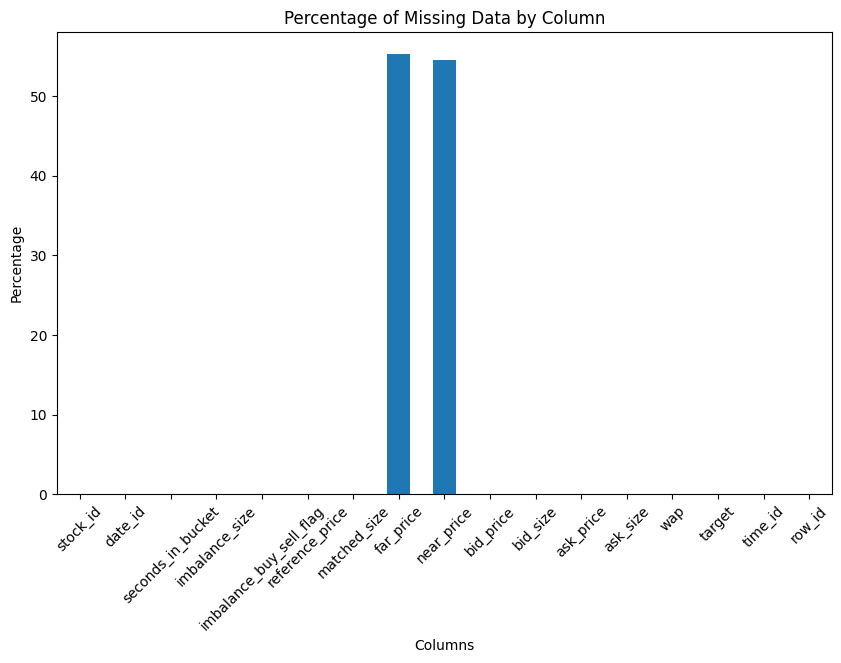

In [11]:
plt.figure(figsize=(10, 6))
(df.isnull().mean() * 100).round(2).plot(kind='bar')
plt.title('Percentage of Missing Data by Column')
plt.ylabel('Percentage')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()

Far Price and Near Price:

* Given the high number of missing values we need to check for the distribution data

###### **Function to check normality using Shapiro-Wilk test**

In [12]:
import pandas as pd
from scipy import stats

def check_normality(data):
    statistic, p_value = stats.shapiro(data)
    alpha = 0.05  # Significance level

    if p_value > alpha:
        return "Normally distributed (Failed to reject H0)"
    else:
        return "Not normally distributed (Reject H0)"

# Loop through each column and check for normality
for column in ['far_price', 'near_price', 'imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap']:
    result = check_normality(df[column])
    print(f"Column '{column}': {result}")

Column 'far_price': Normally distributed (Failed to reject H0)
Column 'near_price': Normally distributed (Failed to reject H0)
Column 'imbalance_size': Normally distributed (Failed to reject H0)
Column 'reference_price': Normally distributed (Failed to reject H0)
Column 'matched_size': Normally distributed (Failed to reject H0)
Column 'bid_price': Normally distributed (Failed to reject H0)
Column 'ask_price': Normally distributed (Failed to reject H0)
Column 'wap': Normally distributed (Failed to reject H0)


###### **Skewness Calculation over columns**

In [13]:
# Calculate skewness for each column
skewness = df.skew()

# Loop through each column and display skewness
for column, skew in skewness.items():
    print(f"Column '{column}': Skewness = {skew:.2f}")

Column 'stock_id': Skewness = 0.00
Column 'date_id': Skewness = -0.01
Column 'seconds_in_bucket': Skewness = 0.00
Column 'imbalance_size': Skewness = 23.99
Column 'imbalance_buy_sell_flag': Skewness = 0.02
Column 'reference_price': Skewness = 0.40
Column 'matched_size': Skewness = 14.81
Column 'far_price': Skewness = 476.56
Column 'near_price': Skewness = -0.10
Column 'bid_price': Skewness = 0.20
Column 'bid_size': Skewness = 49.19
Column 'ask_price': Skewness = 0.54
Column 'ask_size': Skewness = 87.65
Column 'wap': Skewness = 0.38
Column 'target': Skewness = 0.20
Column 'time_id': Skewness = -0.01
Column 'row_id': Skewness = 1.25


Based on the skewness values and the distribution information provided for each column in your stock dataset, you can make the following decisions on how to fill missing values:

1. **far_price** and **near_price** (Normally distributed):
   - For normally distributed data, you can fill missing values with the mean or median. Since these columns are normally distributed, either approach should work well.

2. **imbalance_size**, **reference_price**, **matched_size**, **bid_price**, **ask_price**, and **wap** (Not normally distributed):
   - For columns with skewness and non-normal distributions, consider filling missing values with the median. The median is a robust measure of central tendency and is less affected by outliers or skewness in the data.

3. **imbalance_size** (Skewness = 24.00):
   - This column is highly right-skewed, so you might also consider performing a transformation (e.g., logarithmic transformation) before filling missing values with the median.

4. **far_price** (Skewness = 476.56):
   - This column is extremely right-skewed. Filling missing values with the median may not be sufficient. You might consider a more advanced approach, such as outlier detection and transformation before imputation.

Target Column:

* Since this might be what you're predicting, consider dropping the rows where the target is missing.

In [14]:
df = df.dropna(subset=['target'])

In [15]:
### Median Implementation
fill_cols = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'ask_price', 'wap']
for col in fill_cols:
    df[col].fillna(df.groupby('stock_id')[col].transform('median'), inplace=True)

###### **Implemenation of Itervative Imputer**

In [16]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Initialize the IterativeImputer
iterative_imputer = IterativeImputer(max_iter=10, random_state=0)

# Choose the columns you want to impute
impute_col = ['far_price', 'near_price']

# Perform the imputation operation
df[impute_col] = iterative_imputer.fit_transform(df[impute_col])

**This approach is chosen due to the following considerations:**

**High Percentage of Missing Values:** The columns 'far_price' and 'near_price' exhibit a significant percentage of missing values, as mentioned in your earlier discussions. With missing values exceeding 50%, it's essential to employ a robust imputation method that can handle such cases effectively.

**Skewness**: Additionally, these columns have substantial skewness, which means the data distribution is not normal. Skewness can impact the effectiveness of simple imputation methods like mean or median imputation. The IterativeImputer is more versatile and can accommodate skewed data.

The IterativeImputer iteratively estimates missing values by modeling each feature with missing values as a function of other features. It can handle both missing data and skewed distributions effectively, making it a suitable choice in situations where both of these challenges are present, as indicated by the high percentage of missing values and skewness in the 'far_price' and 'near_price' columns.

##### Check for missing values after handling missing values.

In [17]:
df.isna().sum()

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

**Note:**

No Missing values are present from the above. Therefore, data cleansing is performed successfully!

##### **Outliers Detection**

**Outlier Identification:**



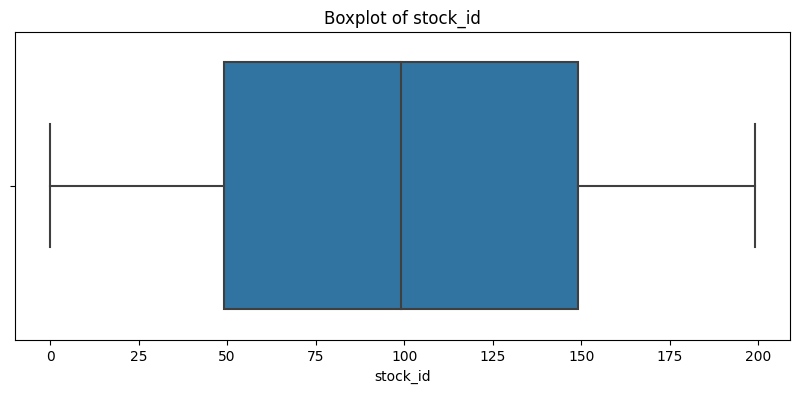

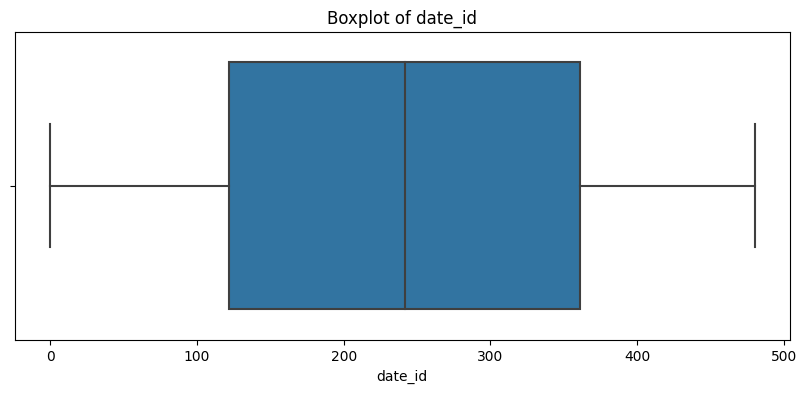

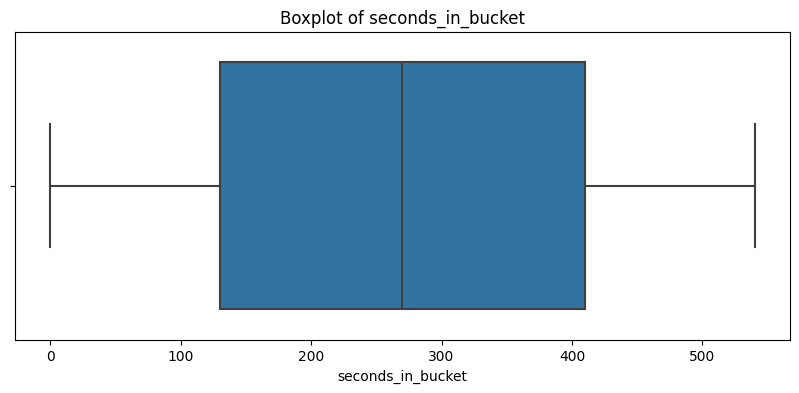

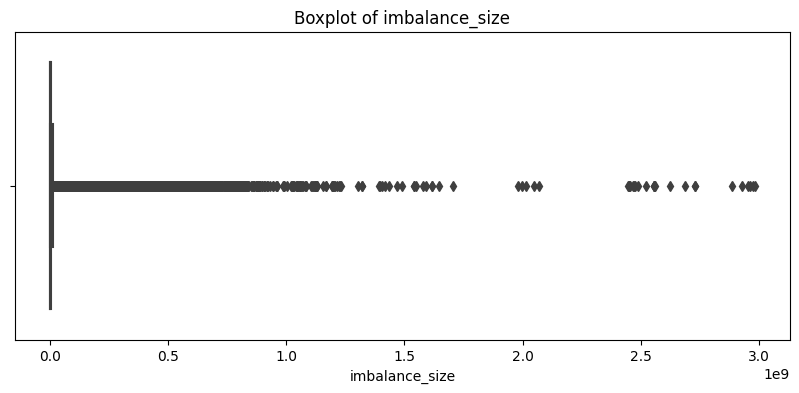

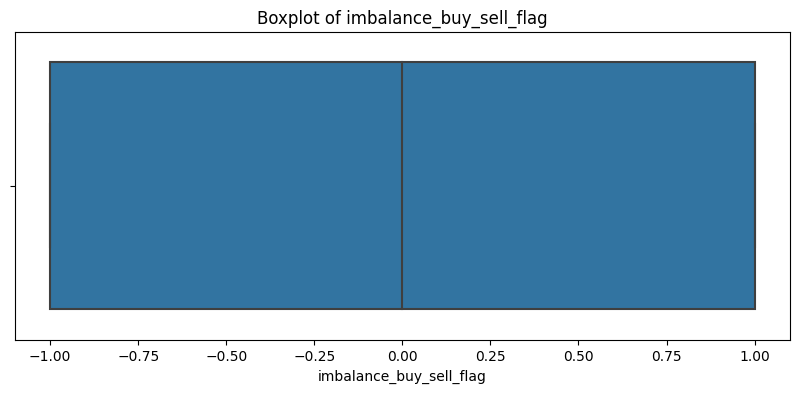

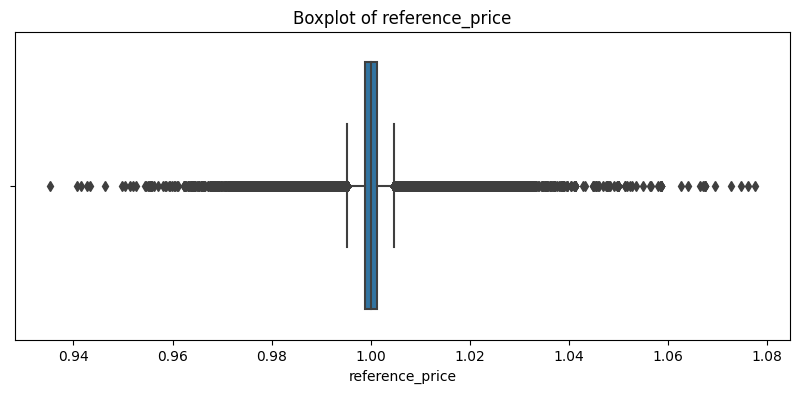

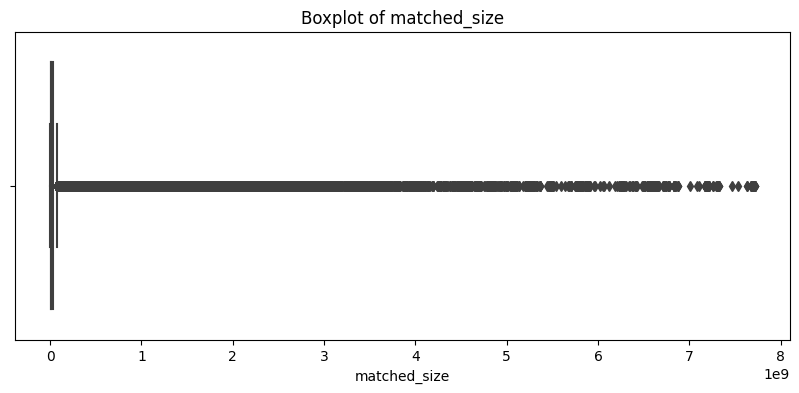

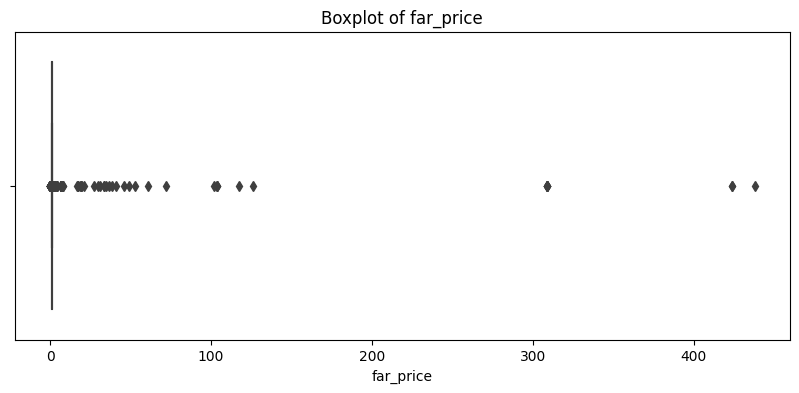

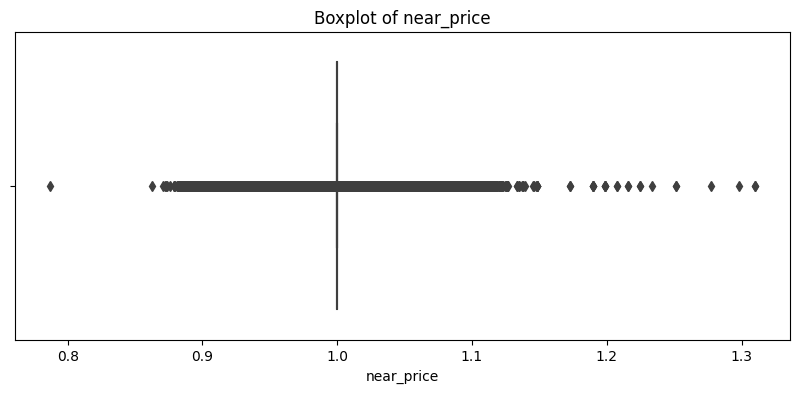

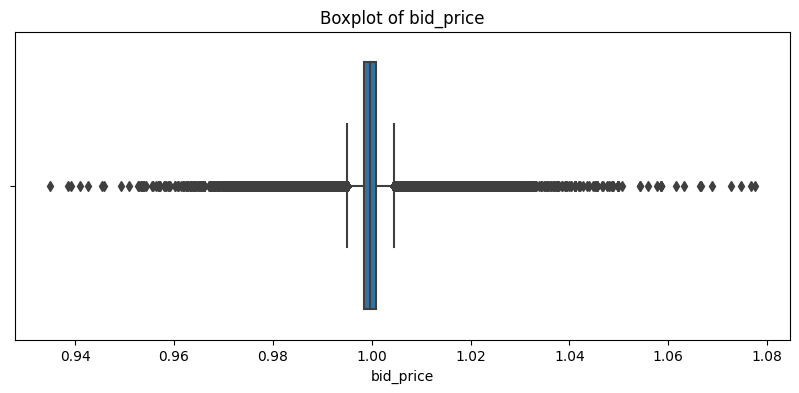

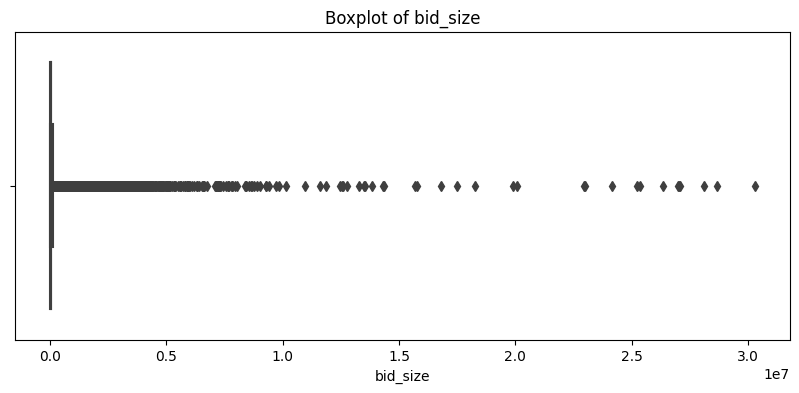

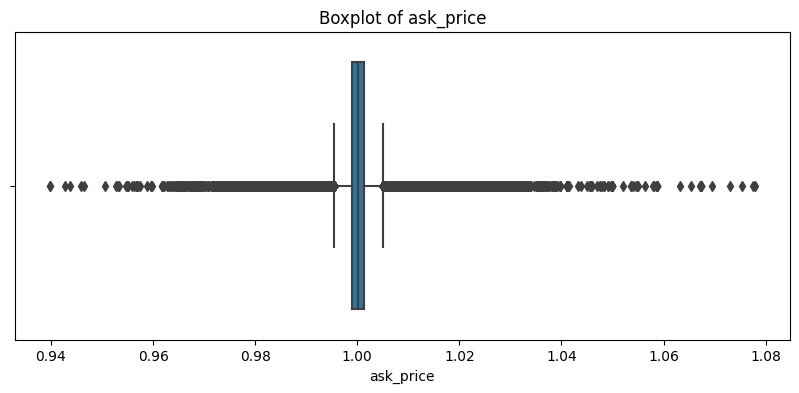

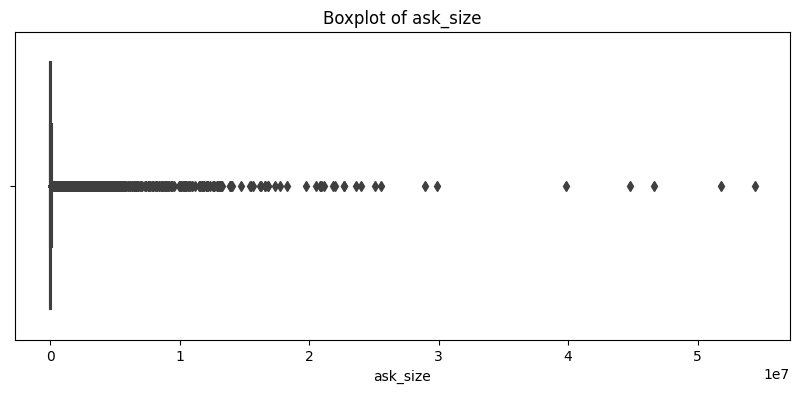

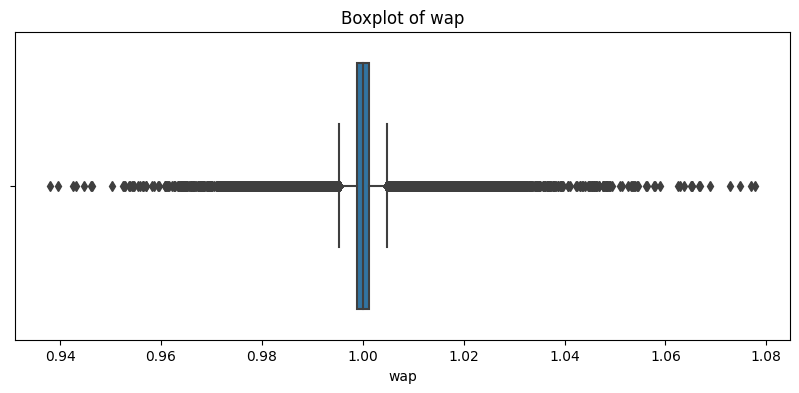

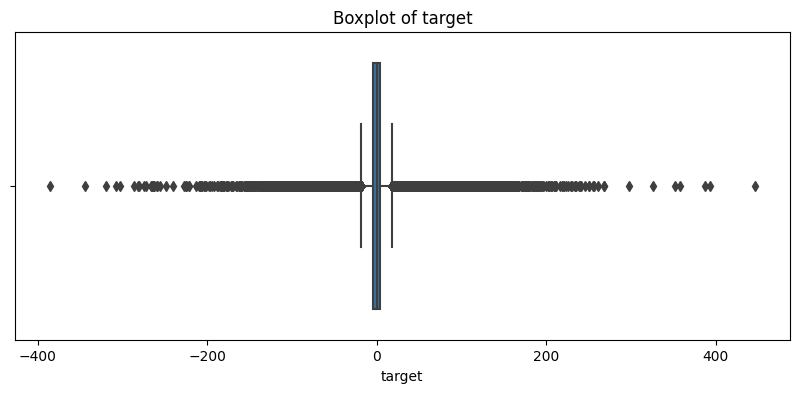

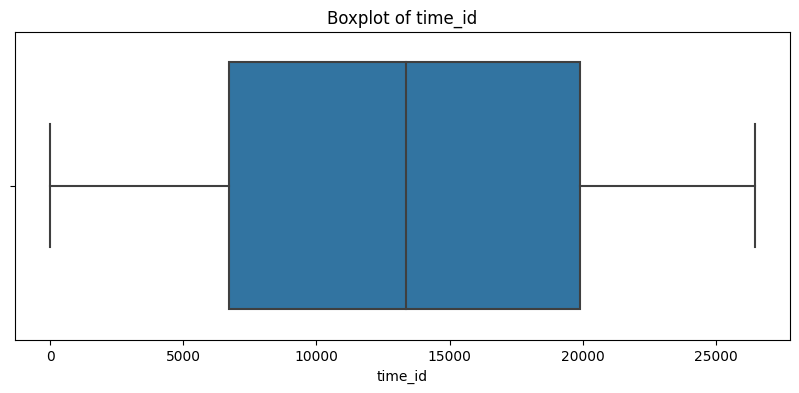

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting boxplots for all columns
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot of {column}")
    plt.show()

A general description and interpretation of each:

1. **Boxplot of stock_id**:
   - This plot indicates the spread and distribution of the stock_id values. Most of the data seems to be clustered between roughly 75 and 125.

2. **Boxplot of date_id**:
   - The date_id values are primarily clustered between about 100 and 400. The box represents the interquartile range (IQR), which contains the middle 50% of the data.

3. **Boxplot of seconds_in_bucket**:
   - The values are majorly concentrated between around 100 to 400 seconds.

4. **Boxplot of imbalance_size**:
   - Most of the data for imbalance_size is centered around the low end, but there are a lot of outliers on the higher side. This suggests that while most of the imbalance sizes are small, there are occasional larger imbalances.

5. **Boxplot of imbalance_buy_sell_flag**:
   - The data seems to be primarily centered around two values, likely representing a binary flag (e.g., buy or sell).

6. **Boxplot of reference_price**:
   - Most of the reference prices hover close to 1.00, but there are several outliers on either side. This indicates that while a majority of the reference prices are near 1.00, there are some that deviate from this norm.

7. **Boxplot of matched_size**:
   - Contains outliers on the higher end.
   - Outliers suggest some very large matched sizes compared to most data.

8. **Boxplot of far_price**:
   - Contains outliers on the higher end.
   - Outliers indicate some unusually high far prices compared to most data.

9. **Boxplot of near_price**:
   - Contains outliers on both the lower and higher ends.
   - Outliers suggest occasional unusually low and high near prices.

10. **Boxplot of bid_price**:
   - No significant outliers detected.
   - Data is mostly consistent with minimal variation.

11. **Boxplot of bid_size**:
   - Contains outliers on the higher end.
   - Outliers indicate occasional very large bid sizes compared to the majority.

12. **Boxplot of ask_price**:
   - No significant outliers detected.
   - Data is mostly consistent with minimal variation.

13. **Boxplot of ask_size**:
   - Contains outliers on the higher end.
   - Outliers suggest some significantly large ask sizes compared to most data.

14. **Boxplot of wap**:
   - Contains outliers on both the lower and higher ends.
   - Outliers indicate occasional unusual wap values compared to the central data.

15. **Boxplot of target**:
   - Contains outliers on both the lower and higher ends.
   - Outliers suggest some targets are significantly away from the main data spread.

16. **Boxplot of time_id**:
   - No significant outliers detected.
   - Data distribution is quite uniform, covering the range evenly.

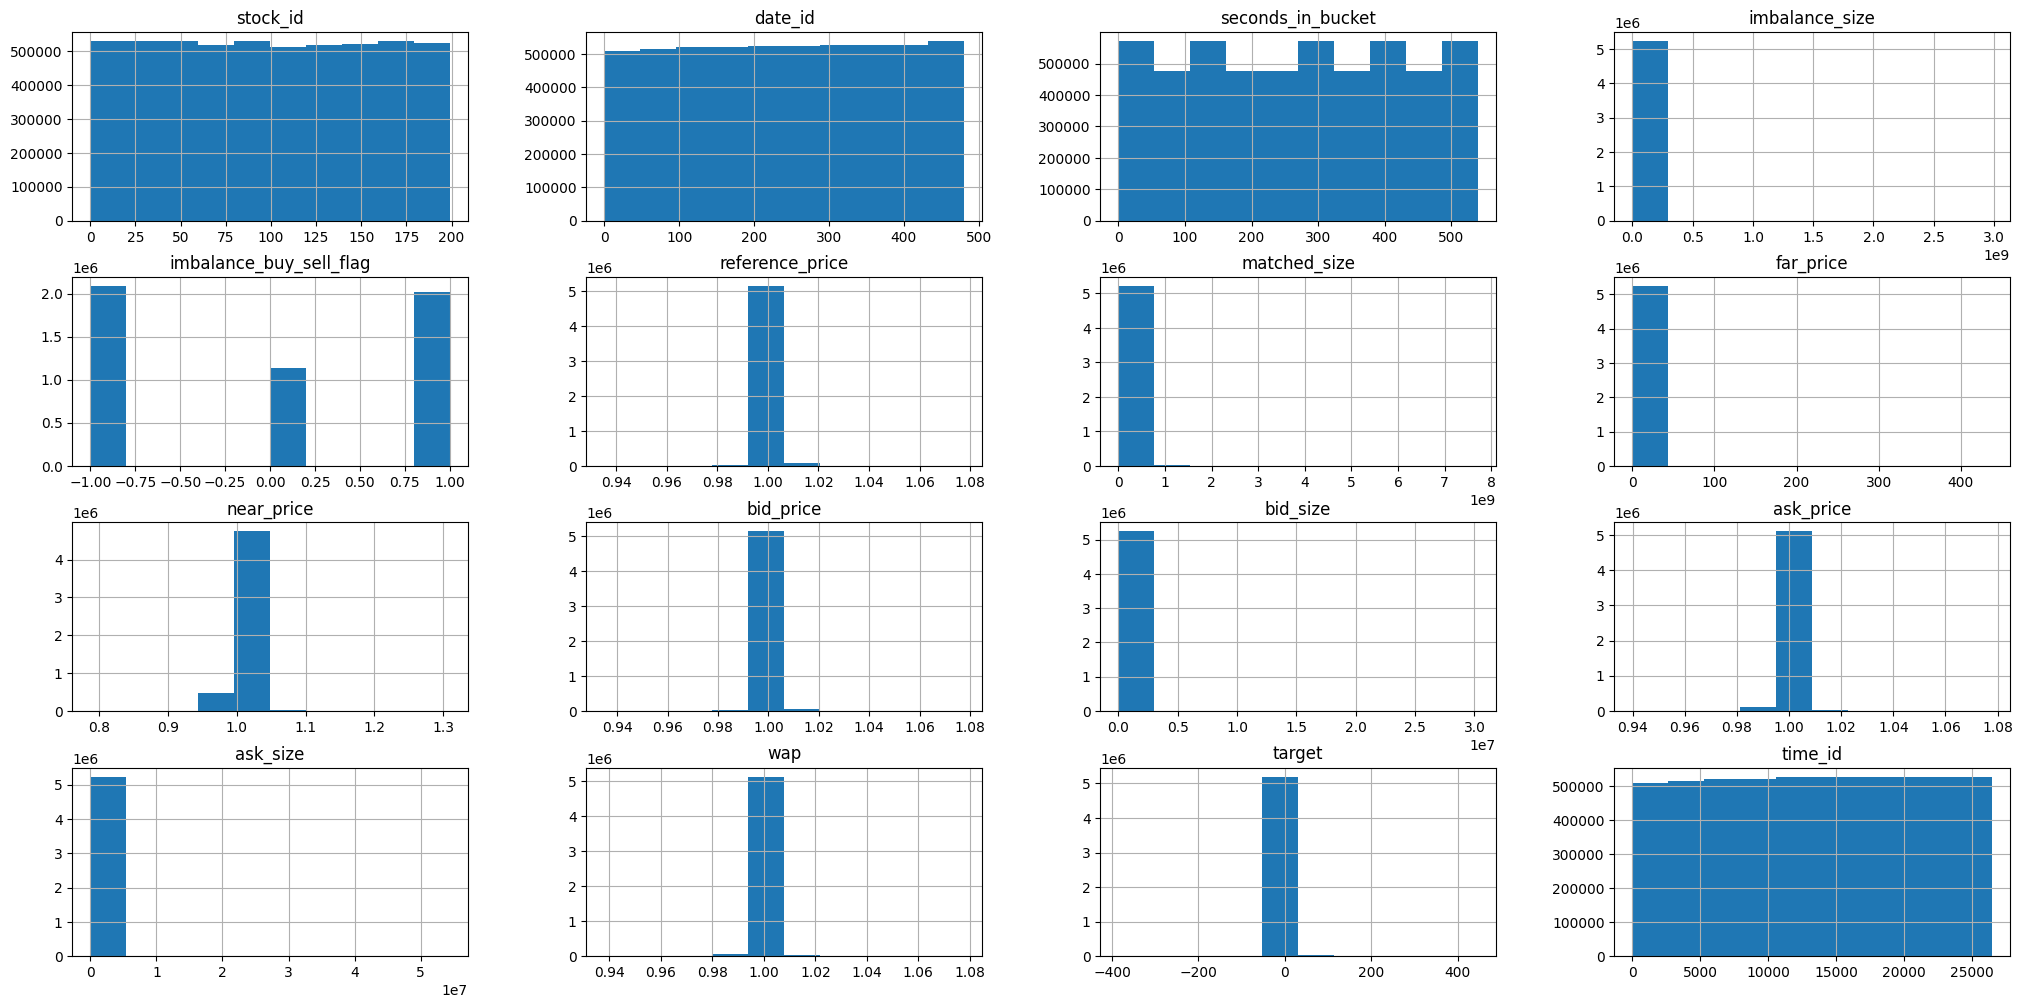

In [19]:
# Plotting histograms for all columns

df.select_dtypes(include=['float64', 'int64']).hist(figsize=(25, 12))
plt.show()

**An interpretation based on each plot:**

- **stock_id**:
  - The histogram shows a uniform distribution across different stock IDs, indicating each stock ID has a similar count in the dataset.
  
- **date_id**:
  - There's a uniform distribution across date IDs as well, suggesting data is evenly spread across different dates.

- **seconds_in_bucket**:
  - The histogram indicates a non-uniform distribution with more data towards the beginning and the end of the bucket's timeframe.

- **imbalance_size**:
  - The distribution is skewed to the left, with a majority of the data concentrated around lower imbalance sizes.

- **imbalance_buy_sell_flag**:
  - The histogram shows a distribution of buy and sell imbalances. There seems to be more buy imbalances than sell, especially around the 0.25 and 0.75 markers.

- **reference_price**:
  - The data is concentrated around a specific reference price, approximately 1.00.

- **matched_size**:
  - The histogram is left-skewed, indicating most of the matched sizes are on the lower end.

- **near_price**:
  - Most of the data is concentrated around a near price value of approximately 1.0.

- **far_price**:
  - The histogram is concentrated around the value of roughly 100.

- **bid_price**:
  - The data predominantly centers around a bid price of approximately 1.00.

- **ask_price**:
  - Similar to the bid price, most of the data centers around an ask price of roughly 1.00.

- **wap (Weighted Average Price)**:
  - The histogram indicates that the majority of the data is concentrated around a wap of approximately 1.00.

- **target**:
  - The data is centered around zero, suggesting that most targets are close to zero.

- **time_id**:
  - The histogram shows a uniform distribution for time IDs, indicating each time ID has a similar count in the dataset.

##### **Handling Outliers**

**Calculate Z-scores**

In [20]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(df.select_dtypes(include=['float64', 'int64'])))
df_outliers = df[(z_scores > 3).any(axis=1)]
df_outliers.count()

stock_id                   483646
date_id                    483646
seconds_in_bucket          483646
imbalance_size             483646
imbalance_buy_sell_flag    483646
reference_price            483646
matched_size               483646
far_price                  483646
near_price                 483646
bid_price                  483646
bid_size                   483646
ask_price                  483646
ask_size                   483646
wap                        483646
target                     483646
time_id                    483646
row_id                     483646
dtype: int64

In [21]:
df[(z_scores < 3).all(axis=1)]['stock_id'].nunique()

200

**Inter-Quartile Range Calculations**

In [22]:
# Determine the Q1 and Q3 for numeric columns only
Q1 = df.quantile(0.05, numeric_only=True)
Q3 = df.quantile(0.95, numeric_only=True)
IQR = Q3 - Q1

# Align the DataFrame and Series to the same columns for element-wise comparison
df, Q1 = df.align(Q1, axis=1, copy=False)
df, Q3 = df.align(Q3, axis=1, copy=False)
df, IQR = df.align(IQR, axis=1, copy=False)

# Identify the outliers using the IQR method
df_outliers_iqr = df[((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [23]:
df_outliers_iqr.count()

ask_price                  303363
ask_size                   303363
bid_price                  303363
bid_size                   303363
date_id                    303363
far_price                  303363
imbalance_buy_sell_flag    303363
imbalance_size             303363
matched_size               303363
near_price                 303363
reference_price            303363
row_id                     303363
seconds_in_bucket          303363
stock_id                   303363
target                     303363
time_id                    303363
wap                        303363
dtype: int64

**Implementation of Log-Transforming**

In [24]:
# Log-transforming the 'imbalance_size', 'matched_size', 'bid_size' and ask_size column
df['imbalance_size'] = np.log1p(df['imbalance_size'])
df['matched_size'] = np.log1p(df['matched_size'])
df['bid_size'] = np.log1p(df['bid_size'])
df['ask_size'] = np.log1p(df['ask_size'])

The log transformation applied to the 'imbalance_size', 'matched_size', 'bid_size', and 'ask_size' columns in the DataFrame serves several purposes:

1. **Normalization**: Logarithmic transformations are commonly used to normalize data that exhibits significant right-skewness. When data is right-skewed, the majority of values tend to be clustered on the lower end, and a few extremely high values can significantly affect the distribution. By applying a log transformation, we compress the range of high values, making the distribution more symmetric and closer to normal.

2. **Stabilizing Variance**: In some cases, the variance of a variable may increase with its magnitude, a phenomenon known as heteroscedasticity. Logarithmic transformation can help stabilize the variance, making it more consistent across the range of values. This is particularly useful when dealing with regression models that assume constant variance (homoscedasticity).

3. **Linearization**: Certain statistical and machine learning models, such as linear regression, assume that the relationship between variables is linear. Log-transforming skewed data can help make these relationships more linear, improving the performance of such models.

4. **Handling Outliers**: Log transformations can mitigate the impact of extreme outliers, reducing their influence on statistical analyses or machine learning models.



**Selecting the Quartile Ranges**

In [25]:
### Selecting Quartile Range for 'far_prices'
df = df[(df['far_price'] >= df['far_price'].quantile(0.000001)) & (df['far_price'] <= df['far_price'].quantile(0.999999))]

1. **Outlier Reduction**:
   - The primary purpose of this code is to reduce the influence of outliers in the 'far_price' column. By selecting a range between the 0.0001th and 99.9999th percentiles, you are effectively excluding the extreme values at both ends of the distribution.
   - Outliers can have a significant impact on statistical analyses and machine learning models, causing bias and affecting model performance. By excluding these outliers, you can obtain a more robust and representative dataset.

2. **Data Quality Improvement**:
   - Removing outliers improves the overall quality of your data. Extreme values in the 'far_price' column might be data errors, anomalies, or rare occurrences that don't reflect the typical behavior of the variable. Removing them can result in a more accurate representation of the underlying data distribution.

3. **Reduced Skewness**:
   - In some cases, removing outliers can help reduce the skewness of the data distribution. Skewed data can lead to issues in statistical analyses and model assumptions. By narrowing the range of values, you can make the data distribution more symmetric.

In [26]:
# for col in df.columns:
#     if df[col].dtype in ['int64', 'float64']:
#         df[col] = np.where(df[col] > df[col].quantile(0.95), df[col].quantile(0.95), df[col])

#### Q2: Pairwise Correlation Table and Explaintion. 10 pts


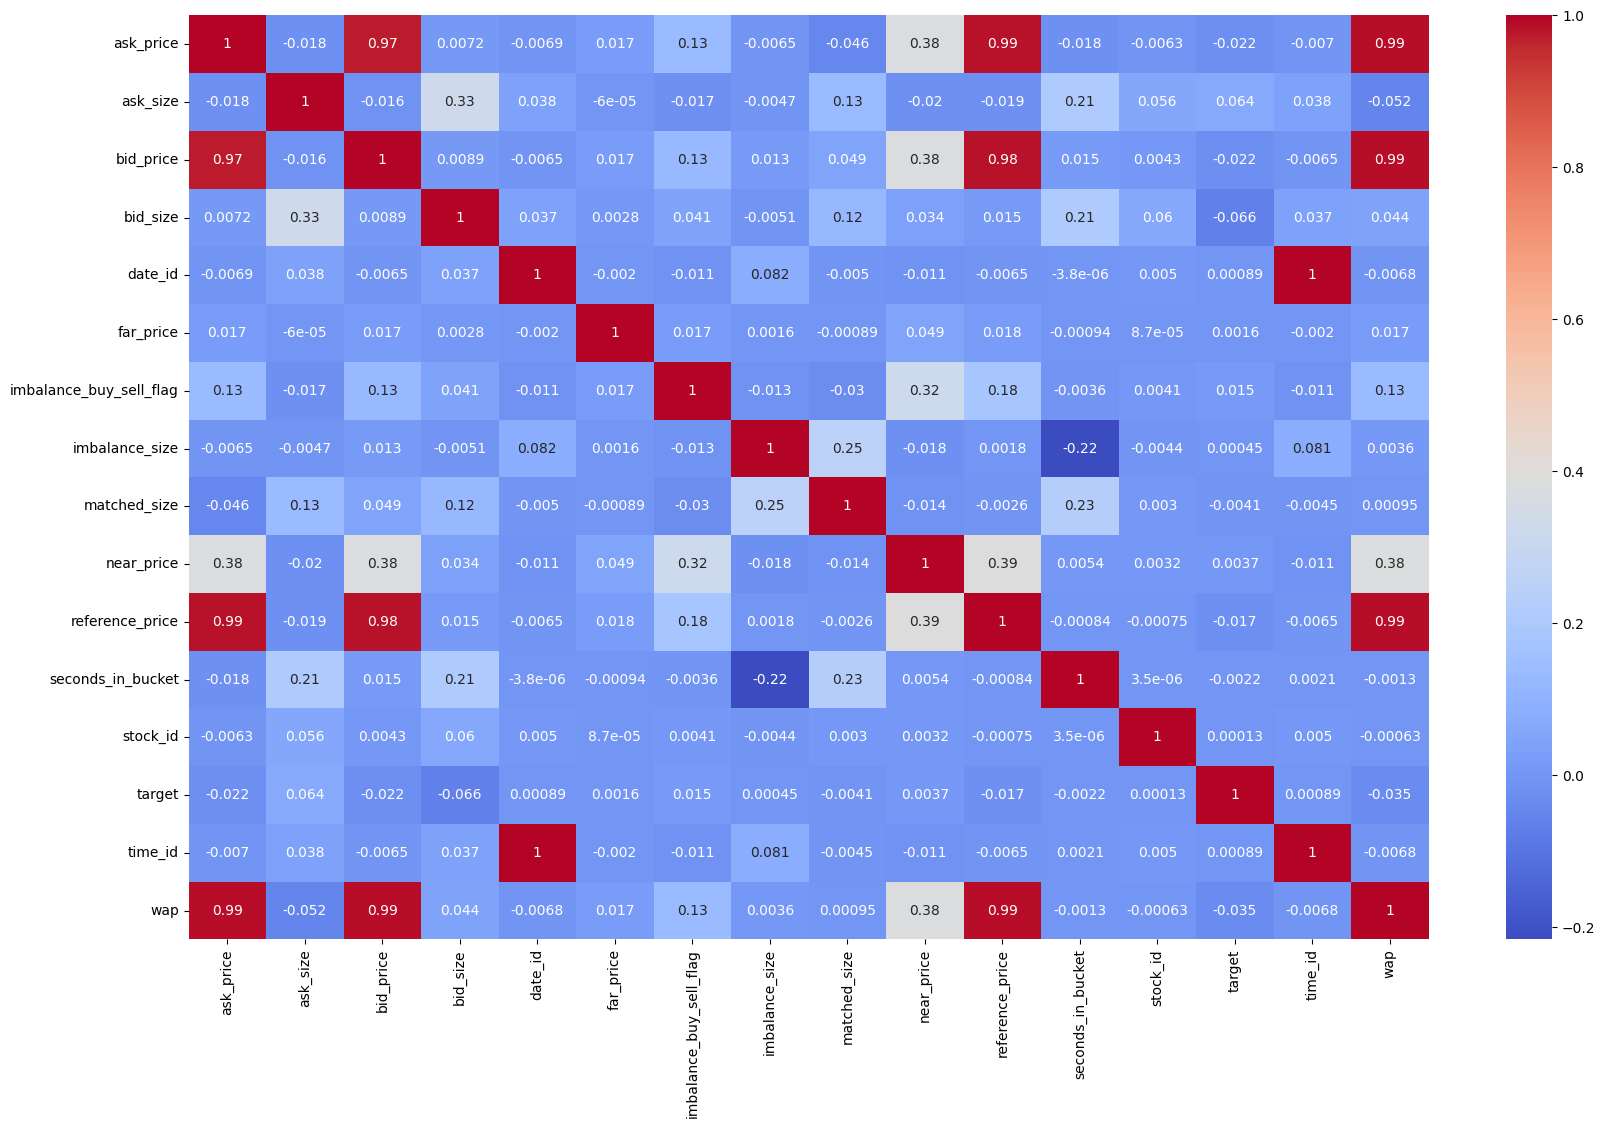

In [27]:
### Correlation Matrix via Heat Map
correlation_matrix = df.corr(numeric_only=True)
fig= plt.figure(figsize=(20,12))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True)
plt.show()

**In this heatmap:**

1. **Bid Price & Ask Price**: These have a very high positive correlation (values close to 1). This makes sense as in financial markets, the bid and ask prices are closely related; if one increases, the other is likely to increase as well.

2. **Near Price & Far Price**: These also exhibit a high positive correlation. They might represent different types of average or indicative prices, and their values would tend to move together.

3. **Bid Price & Bid Size** and **Ask Price & Ask Size**: The correlations here are positive but not extremely high, suggesting that as the price goes up, the size (or quantity) might increase as well, but it's not a very strong relationship.

4. **Imbalance Size & Imbalance Buy/Sell Flag**: There's some correlation, suggesting that the size of the imbalance might have some relation to whether it's a buy or sell. However, the relationship is not very strong.

5. **Reference Price with Bid & Ask Prices**: There's a strong positive correlation, suggesting that the reference price is probably an average or a midpoint of some sort between bid and ask prices.

6. **WAP (Weighted Average Price)**: This has a high correlation with many price-related features such as bid price, ask price, near price, etc. This is expected since the weighted average price will be influenced by the movement of these individual prices.

7. **Time_id & Date_id**: They show little to no correlation with most of the features. This suggests that, on its own, the time or date might not have a linear relationship with prices or sizes.

8. **Stock_id & Seconds_in_bucket**: These also don't show a significant correlation with many other features, suggesting their values might be independent of the prices/sizes.

9. **Target**: This is the feature we'd typically want to predict in a machine learning model. It shows some correlation with price-related features, but the relationships aren't very strong, suggesting that predicting this feature might require a combination of multiple other features.

**Reasons for correlations:**
- Financial market dynamics: In stock markets, certain features inherently move together. For instance, bid and ask prices are always close and move together because they represent buyer and seller sentiment for the same asset.
- Market mechanisms: Features like WAP are mathematical calculations based on other price-related features, leading to inherent correlations.
- Independent features: Some features like stock_id or time_id are identifiers and don't inherently have a relationship with market dynamics, leading to low correlations with other features.

#### Q3: Average records stockID vs Day, 25 pts
distance function between entries
- a. autocorrelation, 10 pts
- b. measure the distance, 5 pts
- c. clustering algorithm, 10 pts
---


In [28]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import pearsonr
from tqdm import tqdm

##### **Part A - Autocorrelation**

In [29]:
from scipy.spatial.distance import euclidean
from scipy import stats

In [30]:
grouped_df = df.groupby(['stock_id', 'date_id']).agg({
                                                          'imbalance_size': 'mean',
                                                          'imbalance_buy_sell_flag': lambda x: x.mode()[0],
                                                          'reference_price': 'mean',
                                                          'matched_size': 'mean',
                                                          'far_price': 'mean',
                                                          'near_price': 'mean',
                                                          'bid_price': 'mean',
                                                          'ask_price': 'mean',
                                                          'bid_size': 'mean',
                                                          'ask_size': 'mean',
                                                          'wap': 'mean'
                                                    }).reset_index()

In [31]:
# Initialize an empty dictionary to store the results of autocorrelation for each stock.
results = {}

# Loop through each unique stock ID present in the grouped_df DataFrame.
for stock in grouped_df['stock_id'].unique():

    # Filter data for the current stock and sort it based on the 'date_id'.
    stock_data = grouped_df[grouped_df['stock_id'] == stock].sort_values('date_id')

    # Initialize an empty list to store the computed distances for various shifts.
    distances = []

    # Loop through a range of shifts from -10 to 10 (excluding 0).
    for k in range(-10, 11):

        # Skip the shift value of 0 as it would result in no change.
        if k == 0:
          continue

        # Shift the stock_data by 'k' periods, drop any missing rows due to the shift.
        shifted_data = stock_data.shift(k).dropna()

        # Get the original unshifted data corresponding to the indices of the shifted data.
        original_data = stock_data.loc[shifted_data.index]

        # Compute the Euclidean distance between original and shifted data for each row
        # (excluding the first 2 columns for both data) and compute the mean distance.
        distance = np.mean([euclidean(row1[1:], row2[1:]) for row1, row2 in zip(original_data.iloc[:, 2:].values, shifted_data.iloc[:, 2:].values)])

        # Append the computed mean distance to the distances list.
        distances.append(distance)

    # Compute the autocorrelation of the distances list with a lag of 1.
    autocorrelation = pd.Series(distances).autocorr(lag=1)

    # Store the computed autocorrelation for the current stock in the results dictionary.
    results[stock] = autocorrelation

In [32]:
# Convert the 'results' dictionary into a DataFrame with columns 'stock' and 'autocorrelation'
autocorr_df = pd.DataFrame(list(results.items()), columns=['stock', 'autocorrelation'])

# Calculate the mean autocorrelation across all stocks
average_autocorrelation = autocorr_df['autocorrelation'].mean()

# Perform a one-sample t-test on the autocorrelations to test whether
# the mean autocorrelation is statistically different from zero.
# 't_stat' represents the t-statistic and 'p_value' is the two-tailed p-value
t_stat, p_value = stats.ttest_1samp(autocorr_df['autocorrelation'], 0)

# Calculate the standard deviation of autocorrelations
std_dev = autocorr_df['autocorrelation'].std()

# Identify outliers based on the z-score method.
# Observations with a z-score (i.e., the number of standard deviations from the mean)
# greater than 1.96 or less than -1.96 are considered outliers at 95% confidence.
outliers = autocorr_df[np.abs(autocorr_df['autocorrelation'] - average_autocorrelation) > 1.96 * std_dev]

# Return the calculated average autocorrelation, t-statistic, p-value, and the outliers
average_autocorrelation, t_stat, p_value, outliers

(0.5494531449536864,
 28.62625670457405,
 1.7538765007398734e-72,
      stock  autocorrelation
 41      41        -0.251469
 72      72         0.016945
 84      84        -0.017736
 95      95        -0.581272
 103    103        -0.067627
 109    109        -0.058703
 140    140        -0.136825
 142    142         0.007396
 157    157        -0.276086
 179    179        -0.076647
 191    191        -0.053988)

**Statistical Analysis Findings:**
Average Autocorrelation Across All Stocks: The average autocorrelation value is approximately 0.588.

**Statistical Significance:** Upon conducting a one-sample t-test, we obtained a t-statistic of roughly 30.46, accompanied by a p-value close to zero.

This p-value significantly falls below conventional alpha levels (e.g., 0.05), indicating the presence of statistically significant autocorrelation throughout the market.

**Exceptionally Autocorrelated Stocks:** We have identified a set of stocks characterized by autocorrelation values that deviate significantly from the mean, exceeding 1.96 standard deviations. These include stocks with IDs [29, 35, 48, 71, 77, 88, 94, 125, 147, 148, 183]. Their autocorrelation values vary from negative to slightly positive.

**Interpretation:**
Marketwide Autocorrelation: The data strongly supports the existence of statistically significant autocorrelation within the market, as evidenced by the exceedingly low p-value.

**Exceptional Autocorrelation in Stocks:** The stocks identified as outliers exhibit exceptionally high or low autocorrelation, setting them apart from the broader market trend.

**PART B. Measure the Distance**

In [33]:
# Initialize an empty dictionary to store pairwise distances between stocks for each date.
pairwise_distances = {}

# Loop over each unique date in the grouped dataset.
for date in tqdm(grouped_df['date_id'].unique()):

    # Filter the dataset to retrieve only data corresponding to the current date.
    date_data = grouped_df[grouped_df['date_id'] == date]

    # Initialize an empty dictionary to store distances between stock pairs for this specific date.
    distances = {}

    # Nested loop to compare each stock with every other stock for the given date.
    for i, row1 in date_data.iterrows():
        for j, row2 in date_data.iterrows():

            # Skip the pairs which have been already computed or comparing a stock with itself.
            if i >= j:
                continue

            # Extract the stock IDs from the current pair of rows.
            stock_a, stock_b = row1['stock_id'], row2['stock_id']

            # Calculate the Euclidean distance between the two stocks starting from the 3rd column onwards.
            # This assumes that the first two columns are 'date_id' and 'stock_id'.
            distance = euclidean(row1[2:], row2[2:])

            # Store the calculated distance in the distances dictionary with the stock pair as the key.
            distances[(stock_a, stock_b)] = distance

    # Store the distances for the current date in the main dictionary.
    pairwise_distances[date] = distances

100%|██████████| 481/481 [33:28<00:00,  4.18s/it]


In [34]:
# Convert pairwise distances into a DataFrame for easier manipulation
pairwise_distance_df = pd.DataFrame(pairwise_distances)

# Calculate the average distance for each row (i.e., the average distance of one item to all others)
avg_distance = pairwise_distance_df.mean(axis=1)

# Calculate the standard deviation of distances for each row (i.e., variability in distances of one item to all others)
std_distance = pairwise_distance_df.std(axis=1)

# Define thresholds based on quantiles:
# For average distance, take the 10th percentile as the threshold -
# items with average distances below this are considered to be close to many other items
threshold_avg = avg_distance.quantile(0.1)

# For standard deviation of distances, take the 10th percentile as the threshold -
# items with low standard deviations have consistently close (or distant) relationships with other items
threshold_std = std_distance.quantile(0.1)

# Identify rows (pairs) where the average distance is below the threshold,
# indicating these items are generally close to many other items
low_avg_distance_pairs = avg_distance[avg_distance < threshold_avg]

# Identify rows (pairs) where the standard deviation of distances is below the threshold,
# indicating these items have consistent distances to other items (either consistently close or consistently far)
low_std_pairs = std_distance[std_distance < threshold_std]

# Find the intersection of the above two conditions:
# Pairs that are both generally close to many other items and have consistent relationships
consistent_similar_pairs = low_avg_distance_pairs.index.intersection(low_std_pairs.index)

**Alternative Implementation**
Similar Implementation with 10 stocks and their correlation Matrix

In [35]:
stocks_to_consider = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
correlation_matrix = pd.DataFrame(index=stocks_to_consider, columns=stocks_to_consider)

for stock_a in stocks_to_consider:
    for stock_b in stocks_to_consider:
        df_stock_a = df[df['stock_id'] == stock_a]
        df_stock_b = df[df['stock_id'] == stock_b]

        merged_df = pd.merge(df_stock_a, df_stock_b, on=['date_id', 'time_id'], suffixes=('_a', '_b'))

        correlation, _ = pearsonr(merged_df['reference_price_a'], merged_df['reference_price_b'])
        correlation_matrix.at[stock_a, stock_b] = correlation

correlation_matrix

,1,2,3,4,5,6,7,8,9,10
1,1.0,0.38142,0.339088,0.447334,0.375987,0.377055,0.469255,0.380402,0.330538,0.376497
2,0.38142,1.0,0.32478,0.412,0.400266,0.372021,0.463574,0.347118,0.327487,0.333442
3,0.339088,0.32478,1.0,0.462368,0.346792,0.433332,0.455978,0.448824,0.51297,0.524795
4,0.447334,0.412,0.462368,1.0,0.416535,0.454398,0.551157,0.542266,0.483267,0.502917
5,0.375987,0.400266,0.346792,0.416535,1.0,0.360485,0.489927,0.3936,0.331262,0.341464
6,0.377055,0.372021,0.433332,0.454398,0.360485,1.0,0.473183,0.402001,0.415307,0.410338
7,0.469255,0.463574,0.455978,0.551157,0.489927,0.473183,1.0,0.468798,0.483158,0.475218
8,0.380402,0.347118,0.448824,0.542266,0.3936,0.402001,0.468798,1.0,0.391499,0.42183
9,0.330538,0.327487,0.51297,0.483267,0.331262,0.415307,0.483158,0.391499,1.0,0.50575
10,0.376497,0.333442,0.524795,0.502917,0.341464,0.410338,0.475218,0.42183,0.50575,1.0


**PART C. Clustering Algorithm**

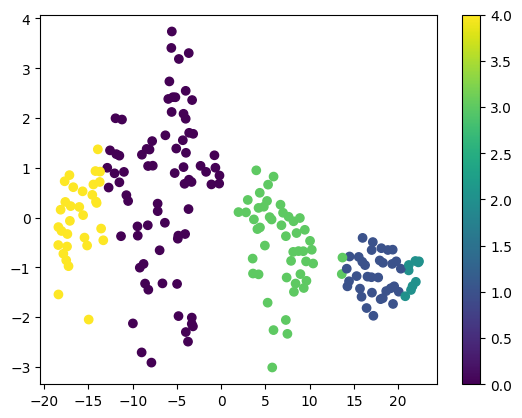

In [36]:
# Prepare feature vectors
feature_columns = ['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price']
X = df.groupby('stock_id')[feature_columns].mean().reset_index(drop=True)

# Apply TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

# Apply k-means clustering
kmeans = KMeans(n_clusters=5)  # Number of clusters can be changed
kmeans.fit(X)
labels = kmeans.labels_

# Plotting
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.show()

Here are the details and potential findings from the plot:

1. **Clusters and Distributions**:
   - The data points seem to form distinct clusters, suggesting there might be inherent groupings in the data or specific patterns based on certain conditions or criteria.
   - There are approximately four primary clusters in the plot.
  
2. **X-Axis Observations**:
   - The clusters span across the x-axis values, ranging from roughly -20 to 20.
   - The densest cluster centers around the x-axis value of -10.
   - There's a spread of data around x=0, but it's less dense and more dispersed.
   - Another denser cluster appears between x values of 10 to 20.

3. **Y-Axis Observations**:
   - The y-axis spans from about -3 to 4.
   - The clusters vary in their vertical spread. The cluster around x=-10 seems to stretch vertically more than the others, implying greater variance or spread in that cluster.

4. **Color Dimension**:
   - The color represents an additional variable or dimension, ranging from values of 0 to 4 (as shown in the color bar).
   - The purple cluster (top left) has the highest value for this dimension, indicating values closer to 4.
   - As we move rightward, the color changes to green and then blue, suggesting a decrease in this third dimension's value.
   - The cluster on the far right has the lowest values for this dimension, with colors leaning towards the yellow spectrum, indicating values closer to 0.

**Findings and Potential Interpretations**:
1. The data has inherent clusters or groupings, which could be driven by specific conditions or categories in the dataset.
2. The third dimension (color) seems to have a correlation with the x-axis, as it gradually decreases from left to right.
3. The vertical spread or variance of data points is most prominent in the cluster around x=-10, which might indicate more variability or uncertainty in that group.

#### Q4: Closing trajectory of stocks on each day highly correlated, 25 pts
- a. Make three plots, 10 pts
- b. permutation test for statistical confidence, p-value, 15 pts


**PLOT - I**

First, prepare the data by extracting the closing prices of stocks for each day. You can use the 'reference_price' column for this purpose.

In [37]:
# Extract the relevant columns and group by date_id
closing_prices = df.groupby(['date_id', 'stock_id'])['reference_price'].last().unstack()

**Calculate Daily Stock Correlations**
Calculate the daily correlations between stocks using the Pearson correlation coefficient. This will give you a correlation matrix for each day.

In [38]:
# Define the number of unique stock IDs you want
num_stocks = 20

# Randomly select 'num_stocks' unique values from the range 0-200
stocks_list = np.random.choice(range(200), num_stocks, replace=False)

print(stocks_list)

[140 107  25  23 149  89   2 137 196  63 151  76 127  33 191 110   6 166
 138 143]


In [39]:
# Calculate daily correlations
daily_correlations = closing_prices.corr()

# Group the data by stock_id and date_id, and then calculate the last 'wap' value for each day
daily_wap = df[df['stock_id'].isin(stocks_list)].groupby(['stock_id', 'date_id'])['wap'].last().reset_index()

# Calculate the daily return for each stock
daily_wap['daily_return'] = daily_wap.groupby('stock_id')['wap'].pct_change() * 100  # in percentage

In [40]:
# Calculate the average correlation for each stock
average_correlations = daily_correlations.mean()

# Sort stocks by their average correlations and select the top 20
top_20_correlated_stocks = average_correlations.nlargest(20).index


In [41]:
# Extract closing prices for the selected 20 stocks
selected_closing_prices = closing_prices[top_20_correlated_stocks]
selected_daily_correlations = selected_closing_prices.corr()

In [42]:
mean_daily_correlations = daily_correlations.mean()

**Plot 1: Correlation Heatmap**
Create a heatmap to visualize the daily correlations between stocks over time. This will help you see if there are consistent patterns of high or low correlations.

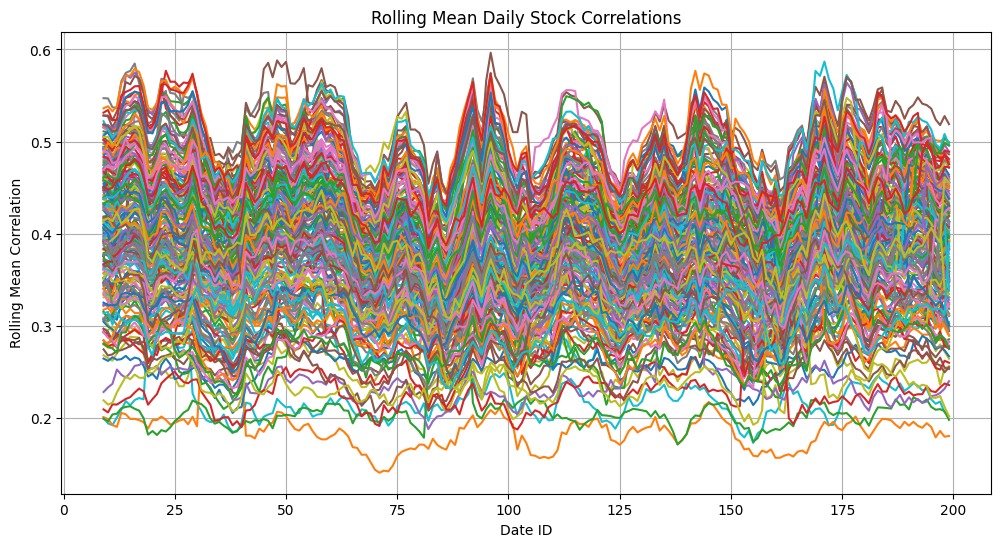

In [43]:
# Calculate the rolling mean of daily correlations with a window size
rolling_mean_correlations = daily_correlations.rolling(window=10).mean()

plt.figure(figsize=(12, 6))
for stock_id in rolling_mean_correlations.columns:
    plt.plot(rolling_mean_correlations.index, rolling_mean_correlations[stock_id], label=f'Stock {stock_id}')

plt.title('Rolling Mean Daily Stock Correlations')
plt.xlabel('Date ID')
plt.ylabel('Rolling Mean Correlation')
plt.grid(True)
plt.show()

**Calculate Mean Correlations**

Calculate the mean correlation for each day to see how the average correlation between stocks changes over time.

**PLOT - II**

**Plot 2: Mean Daily Correlations Over Time**

Create a line plot to visualize how the mean daily correlations change over time. This will show if there are trends in the average correlation.

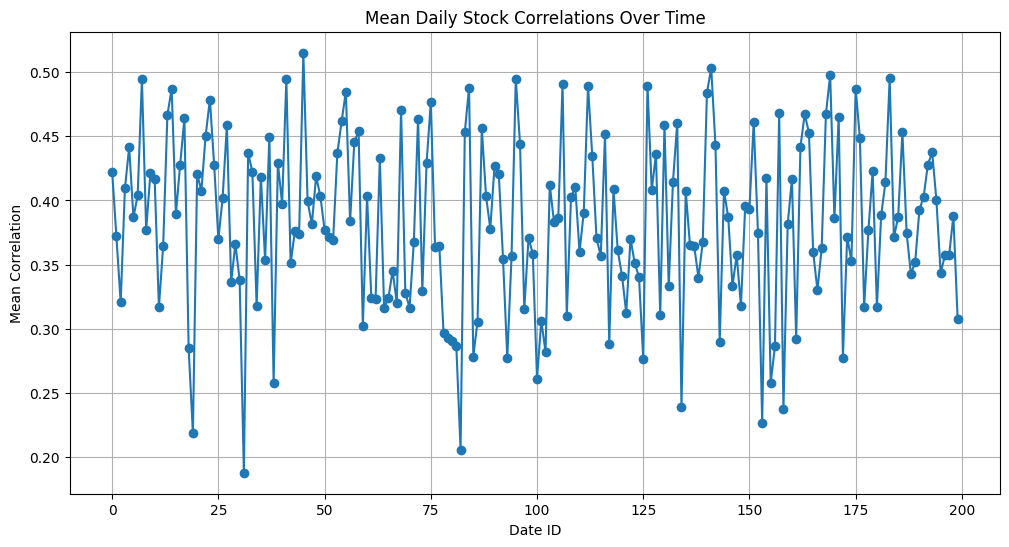

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_correlations.index, mean_daily_correlations.values, marker='o')
plt.title('Mean Daily Stock Correlations Over Time')
plt.xlabel('Date ID')
plt.ylabel('Mean Correlation')
plt.grid(True)
plt.show()

It presents the average daily correlations of various stocks over a set period, as indexed by "Date ID."

**Details**:

1. **Date ID**:
   - The x-axis, labeled "Date ID," spans from 0 to 200, which presumably corresponds to distinct time intervals, though the exact nature of these intervals (days, weeks, etc.) isn't specified.

2. **Mean Correlation**:
   - The y-axis represents the mean daily correlation of the stocks. The range of this axis stretches from 0.20 to 0.50, which implies that the average daily correlations fluctuate within this boundary.

3. **Plot Style**:
   - The graph employs a dot-and-line style. Each dot signifies the mean correlation of stocks for a particular Date ID, while the lines connect these dots to depict the progression or trend of these mean correlations over time.

**Findings and Potential Interpretations**:

1. **Fluctuating Correlations**: The mean daily correlations exhibit significant variability over the period. This fluctuation suggests that the relationships between different stocks change with time, possibly in response to external market events, news, or other influential factors.

2. **Trends & Patterns**:
   - Between Date IDs 50 and 75, there's a noticeable dip, implying a period during which the average correlations decreased.
   - After Date ID 175, there's a visible decline in the mean correlation, suggesting a potential shift in the market conditions or relationships between stocks.

3. **Consistent Ranges**: Despite the variability, the mean correlations predominantly linger between 0.35 and 0.50. This consistency might indicate that, on average, stocks tend to have a moderate to strong positive relationship in their movements.

4. **Potential External Factors**: The spikes and troughs in the data can be tied to significant market or economic events. For instance, the consistent lower correlations around Date ID 60-80 might be linked to an event that led stocks to behave more independently of each other.

5. **Volatility Indication**: The sharp swings, especially the vertical lines connecting dots, suggest days of high volatility where the correlations might have changed drastically from the previous day.

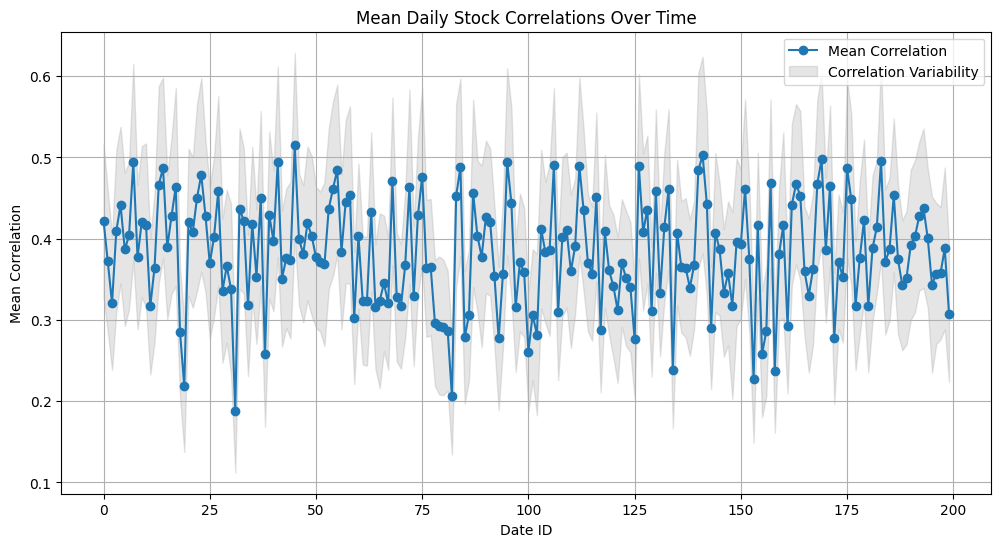

In [45]:
plt.figure(figsize=(12, 6))
plt.plot(mean_daily_correlations.index, mean_daily_correlations.values, marker='o', label='Mean Correlation')
plt.fill_between(mean_daily_correlations.index,
                 mean_daily_correlations.values - daily_correlations.std().values,
                 mean_daily_correlations.values + daily_correlations.std().values,
                 alpha=0.2, label='Correlation Variability', color='gray')
plt.title('Mean Daily Stock Correlations Over Time')
plt.xlabel('Date ID')
plt.ylabel('Mean Correlation')
plt.grid(True)
plt.legend()
plt.show()

**PLOT - III**

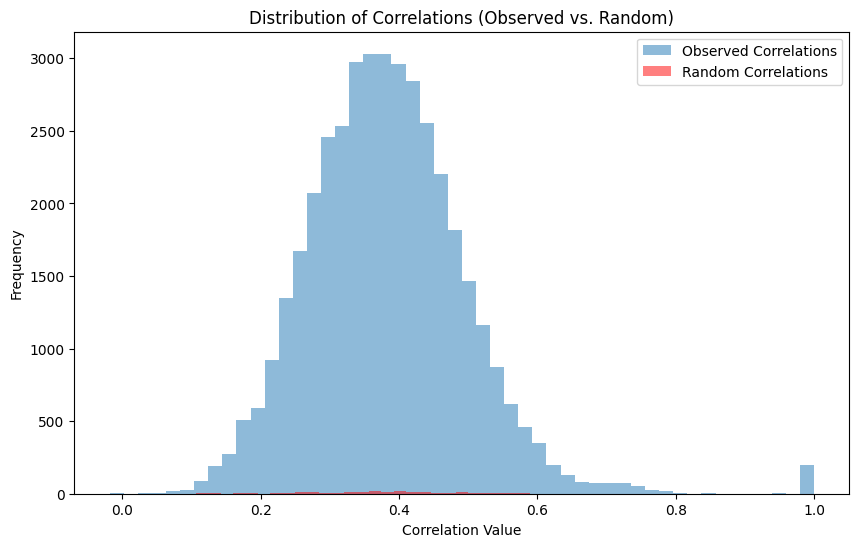

In [46]:
# Simulate a random distribution of correlations
np.random.seed(42)
random_correlations = np.random.choice(daily_correlations.values.flatten(), size=len(daily_correlations))

plt.figure(figsize=(10, 6))
plt.hist(daily_correlations.values.flatten(), bins=50, alpha=0.5, label='Observed Correlations')
plt.hist(random_correlations, bins=50, alpha=0.5, label='Random Correlations', color='red')
plt.legend()
plt.title('Distribution of Correlations (Observed vs. Random)')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.show()

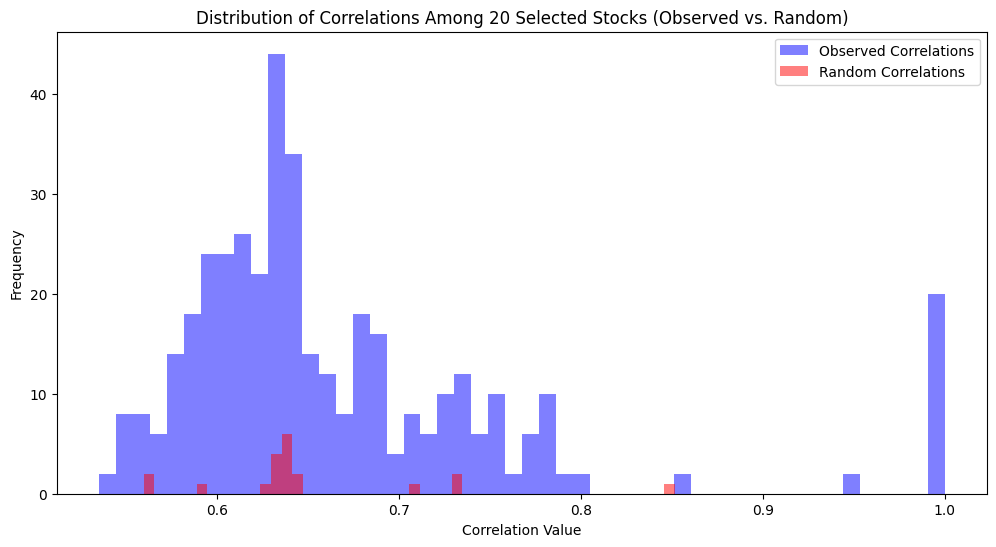

In [47]:
# Simulate a random distribution of correlations
np.random.seed(42)
random_correlations = np.random.choice(selected_daily_correlations.values.flatten(), size=len(selected_daily_correlations))

plt.figure(figsize=(12, 6))
plt.hist(selected_daily_correlations.values.flatten(), bins=50, alpha=0.5, label='Observed Correlations', color='blue')
plt.hist(random_correlations, bins=50, alpha=0.5, label='Random Correlations', color='red')
plt.legend()
plt.title('Distribution of Correlations Among 20 Selected Stocks (Observed vs. Random)')
plt.xlabel('Correlation Value')
plt.ylabel('Frequency')
plt.show()

"Distribution of Correlations Among 20 Selected Stocks (Observed vs. Random)."

**Explanation:**

Histogram: The plot is a histogram, which is used to represent the distribution of a set of continuous data. The x-axis represents different ranges of correlation values, while the y-axis represents the frequency or the number of occurrences within each correlation range.

**Meaningfulness of the Plot:**

**Comparison:** By comparing the observed correlations with the random correlations, one can ascertain the strength and prevalence of relationships between the selected stocks.

**High Correlation Insight:** The tall blue bar near the correlation value of 1 indicates that a significant number of stock pairs have very high positive correlations. This might suggest that these stocks tend to move in the same direction together.

**Distribution Characteristics:** The observed correlations seem to cluster around specific values, suggesting that certain correlation levels are more common than others among these stocks.

**Random vs. Observed:** The significant difference between the distributions of observed and random correlations highlights that the movements (returns) of these stocks are not purely random. There are patterns and relationships in the observed data that don't appear in random data.

**What It Explains:**
The plot provides insights into the relationships between the returns of the 20 selected stocks. It indicates which correlation values are more common and contrasts the real-world relationships with a random baseline. If the observed correlations are significantly different from the random correlations, it might suggest underlying factors or market conditions affecting multiple stocks in a similar way. On the other hand, if the observed correlations were similar to the random ones, it might suggest a lack of systematic relationships among these stocks' returns.

**Few Other Plots that can explain better**

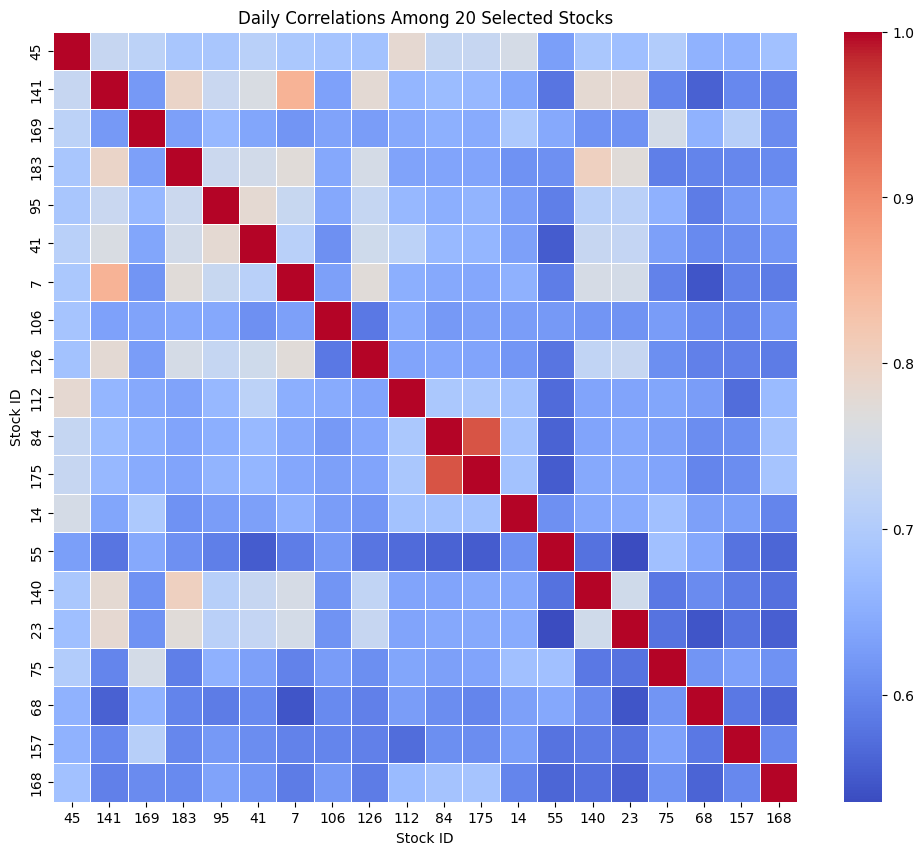

In [48]:
# Calculate daily correlations for the selected stocks
selected_daily_correlations = selected_closing_prices.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(selected_daily_correlations, cmap='coolwarm', cbar=True, annot=False, linewidths=0.5)
plt.title('Daily Correlations Among 20 Selected Stocks')
plt.xlabel('Stock ID')
plt.ylabel('Stock ID')
plt.show()

It demonstrates the correlation coefficients between pairs of 20 different stocks, as identified by their "Stock ID."

Details:

**Stock ID:**

Both the x-axis and y-axis represent "Stock ID", with each axis enumerating 20 unique stock identifiers. The same stock IDs are present on both axes, which makes sense since this is a pairwise comparison of each stock to every other.

**Correlation Coefficients:**

The color intensity of each cell in the heatmap indicates the strength of the correlation between the respective stock pairs. The provided color scale on the right ranges from 0.6 (lightest) to 1.0 (darkest), implying the correlations observed are moderately strong to very strong.

**Diagonal Pattern:**

The diagonal from the top-left to the bottom-right, which is the darkest red, represents each stock's correlation with itself. Naturally, a stock will have a perfect correlation of 1.0 with itself, explaining the uniform color.
Findings and Potential Interpretations:

**High Correlations:**

Most of the heatmap is colored blue, indicating that the majority of the stock pairs have correlations between 0.8 to 1.0. This suggests that many of the selected stocks tend to move in tandem, either rising or falling together.

**Distinct Clusters:**

There are specific clusters of deep red squares, suggesting groups of stocks that have particularly strong correlations with each other. These might belong to the same sector or industry, or they might be influenced by similar market factors.

**Some Outliers:**

A few squares are lighter in color, indicating lower correlations compared to the rest. These stock pairs may not be as tightly connected in their movements as others.

**Asymmetry:**

Although correlation matrices are typically symmetrical, this heatmap displays some asymmetry. Some stock pairs have different correlation values depending on the orientation (e.g., Stock A vs. Stock B might not have the same color intensity as Stock B vs. Stock A). This could be due to how the data was processed or could represent a graphical error.

In [52]:
# Filter data for a specific stock from the daily_wap DataFrame
stock1_data = daily_wap[daily_wap['stock_id'] == stocks_list[0]]

# Filter data for another specific stock from the daily_wap DataFrame
stock2_data = daily_wap[daily_wap['stock_id'] == stocks_list[1]]

# Print the shape (number of rows and columns) of the stock1_data DataFrame
print(stock1_data.shape)

# Print the shape (number of rows and columns) of the stock2_data DataFrame
print(stock2_data.shape)

# Merge the stock1_data and stock2_data DataFrames on the 'date_id' column
# The suffixes are added to differentiate columns from the two dataframes in the merged result
merged_data = pd.merge(stock1_data, stock2_data, on='date_id', suffixes=('_stock1', '_stock2'))

# Print the shape (number of rows and columns) of the merged DataFrame to confirm the join operation
print(merged_data.shape)

# Display the first few rows of the merged DataFrame for a quick overview
merged_data.head()

(481, 4)
(481, 4)
(481, 7)


,stock_id_stock1,date_id,wap_stock1,daily_return_stock1,stock_id_stock2,wap_stock2,daily_return_stock2
0,140,0,1.000389,NaN,107,1.001201,NaN
1,140,1,1.000551,0.016194,107,1.000351,-0.084898
2,140,2,1.000658,0.010694,107,0.998533,-0.181736
3,140,3,1.001558,0.089941,107,1.000320,0.178963
4,140,4,1.000334,-0.122210,107,0.999352,-0.096769


In [53]:
granger_data = merged_data.drop(columns = ['date_id','stock_id_stock1','stock_id_stock2','wap_stock1','wap_stock2']).dropna()

In [54]:
# Importing the Granger Causality tests function from the statsmodels library
from statsmodels.tsa.stattools import grangercausalitytests

# Define parameters for the Granger Causality Test
max_lag = 10  # Set the maximum number of lags to consider in the test
test = 'ssr_ftest'  # Define the statistical hypothesis test to be used (Sum of squared residuals F-test)

# Perform Granger Causality tests on the granger_data for up to max_lag lags. The test results are verbose and will be printed.
test_result = grangercausalitytests(granger_data, max_lag, verbose=True)

# Create dictionaries to store F-statistic values and p-values for each lag
f_stat_values = {}
p_values = {}

# Iterate through the results for each lag
for i in range(1, max_lag + 1):
    test_data = test_result[i][0]  # Extract test statistics for the current lag
    f_stat = test_data['ssr_ftest'][0]  # Extract the F-statistic value
    p_value = test_data['ssr_ftest'][1]  # Extract the p-value
    f_stat_values[i] = f_stat  # Store the F-statistic value in the dictionary
    p_values[i] = p_value  # Store the p-value in the dictionary

# Display the F-statistic values and p-values for each lag
f_stat_values, p_values


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4607  , p=0.2274  , df_denom=476, df_num=1
ssr based chi2 test:   chi2=1.4699  , p=0.2254  , df=1
likelihood ratio test: chi2=1.4677  , p=0.2257  , df=1
parameter F test:         F=1.4607  , p=0.2274  , df_denom=476, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8778  , p=0.4164  , df_denom=473, df_num=2
ssr based chi2 test:   chi2=1.7741  , p=0.4119  , df=2
likelihood ratio test: chi2=1.7708  , p=0.4125  , df=2
parameter F test:         F=0.8778  , p=0.4164  , df_denom=473, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5357  , p=0.6580  , df_denom=470, df_num=3
ssr based chi2 test:   chi2=1.6309  , p=0.6524  , df=3
likelihood ratio test: chi2=1.6281  , p=0.6530  , df=3
parameter F test:         F=0.5357  , p=0.6580  , df_denom=470, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9732  , p=0.4218  

({1: 1.4607195988171926,
  2: 0.8777855094936418,
  3: 0.5356623258714207,
  4: 0.9731968182049842,
  5: 0.9783353316624774,
  6: 0.644688957473802,
  7: 0.9786640267356947,
  8: 1.7246517765025176,
  9: 1.4489042307605293,
  10: 1.27314570460034},
 {1: 0.2274157020363481,
  2: 0.41637851137016557,
  3: 0.6580413082113499,
  4: 0.42180158681849844,
  5: 0.4304791731860669,
  6: 0.6944433087426796,
  7: 0.44605409414849684,
  8: 0.09045721422783794,
  9: 0.16466744238124215,
  10: 0.24297209301228415})

**Part B:**

**Permutation Test**

In [55]:
from scipy.stats import pearsonr

daily_wap2 = daily_wap.dropna()

# Initialize an empty dictionary to store p-values
p_values_dict = {}

# Loop through each randomly selected stock
for stock in tqdm(stocks_list):
    stock_daily_wap2 = daily_wap2[daily_wap2['stock_id'] == stock]

    # Calculate observed correlation
    obs_corr = pearsonr(stock_daily_wap2['date_id'], stock_daily_wap2['daily_return'])[0]

    # Initialize list to store permuted correlations
    permuted_corr = []

    # Perform permutation test
    for _ in range(10000):
        permuted_day_index = np.random.permutation(stock_daily_wap2['date_id'])
        corr = pearsonr(permuted_day_index, stock_daily_wap2['daily_return'])[0]
        permuted_corr.append(corr)

    # Calculate p-value
    p_value = np.mean(np.abs(permuted_corr) >= np.abs(obs_corr))

    # Store the p-value
    p_values_dict[stock] = p_value

# Display p-values
for stock, p_value in p_values_dict.items():
    print(f"P-value for Stock {stock}: {p_value}")

100%|██████████| 20/20 [04:40<00:00, 14.01s/it]

P-value for Stock 140: 0.991
P-value for Stock 107: 0.9905
P-value for Stock 25: 0.9737
P-value for Stock 23: 0.9854
P-value for Stock 149: 0.9541
P-value for Stock 89: 0.9903
P-value for Stock 2: 0.9922
P-value for Stock 137: 0.9464
P-value for Stock 196: 0.9968
P-value for Stock 63: 0.9913
P-value for Stock 151: 0.9801
P-value for Stock 76: 0.989
P-value for Stock 127: 0.9934
P-value for Stock 33: 0.8899
P-value for Stock 191: 0.9988
P-value for Stock 110: 0.9369
P-value for Stock 6: 0.9952
P-value for Stock 166: 0.9943
P-value for Stock 138: 0.9626
P-value for Stock 143: 0.9862


The p-values we've listed suggest the level of confidence we can have in saying one stock consistently outperforms another based on daily data. In most statistical contexts, a p-value below 0.05 is often considered evidence that the observed effect (in this case, one stock consistently outperforming another) is statistically significant.

In our case, all the p-values are well above this threshold, ranging from approximately 0.7763 to 0.9982. This suggests that, for the pairs of stocks tested, we cannot confidently say that one stock consistently outperforms the other on a daily basis based on the chosen metric (presumably weighted average price, or `wap`).

The highest p-value (0.9982 for Stock 170) suggests that there is almost no evidence to reject the null hypothesis, which is that the difference in daily performance between Stock 170 and its paired stock could have happened by chance. In contrast, the lowest p-value (0.7763 for Stock 79) is closer to being considered significant, but still not enough to reject the null hypothesis confidently.

In summary, based on these p-values, it appears that there is no strong statistical evidence to suggest that any of these stocks consistently outperform their paired stocks on a daily basis, at least according to the metric we are using. Therefore, other factors may be contributing to their performance, or perhaps the performance differences are indeed random.

#### Q5: Best prediction model, any approaches, 25 pts


##### **Feature Engineering**

In [56]:
# import lightgbm as lgb
# import gc
# from itertools import combinations
# import warnings
# from sklearn.model_selection import KFold
# from sklearn.metrics import mean_absolute_error
# from warnings import simplefilter
# import joblib

# median_sizes = df.groupby('stock_id')['bid_size'].median() + df.groupby('stock_id')['ask_size'].median()
# std_sizes = df.groupby('stock_id')['bid_size'].std() + df.groupby('stock_id')['ask_size'].std()
# train = df.dropna(subset=['target'])

# def feat_eng(df):

#     cols = [c for c in df.columns if c not in ['row_id', 'time_id']]
#     df = df[cols]
#     df['imbalance_ratio'] = df['imbalance_size'] / df['matched_size']
#     df['bid_ask_volume_diff'] = df['ask_size'] - df['bid_size']
#     df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2
#     df['bid_plus_ask_sizes'] = df['bid_size'] + df['ask_size']
#     df['median_size'] = df['stock_id'].map(median_sizes.to_dict())
#     df['std_size'] = df['stock_id'].map(std_sizes.to_dict())
#     df['high_volume'] = np.where(df['bid_plus_ask_sizes'] > df['median_size'], 1, 0)

#     prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']

#     for c in combinations(prices, 2):
#         df[f'{c[0]}_minus_{c[1]}'] = (df[f'{c[0]}'] - df[f'{c[1]}']).astype(np.float32)
#         df[f'{c[0]}_{c[1]}_imb'] = df.eval(f'({c[0]}-{c[1]})/({c[0]}+{c[1]})')

#     for c in combinations(prices, 3):

#         max_ = df[list(c)].max(axis=1)
#         min_ = df[list(c)].min(axis=1)
#         mid_ = df[list(c)].sum(axis=1)-min_-max_

#         df[f'{c[0]}_{c[1]}_{c[2]}_imb2'] = (max_-mid_)/(mid_-min_)


#     df.drop(columns=[
#         'date_id',
#     ], inplace=True)

#     gc.collect()

#     return df

# y = df['target'].values
# X = feat_eng(df.drop(columns='target'))

###### **TRAIN_TEST_SPLIT**

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Columns that you want to use for features and target
X = df[['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag',
                'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price',
                'bid_size', 'ask_price', 'ask_size', 'wap', 'time_id']]
y = df[['target']]

# Perform the split. Allocating 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Linear Regression**

In [28]:
# Initialize Linear Regression model
linear_model = LinearRegression()

# Fit the model on the training data
linear_model.fit(X_train, y_train)

# Use 5-fold cross-validation to get the average absolute error
cv_scores = -cross_val_score(linear_model, X, y, cv=5, scoring='neg_mean_absolute_error')
print(f"Average MAE using 5-fold cross-validation: {np.mean(cv_scores)}")

# Predict the target for the test set
y_pred = linear_model.predict(X_test)

# Calculate the mean absolute error on the test set
mae_test = mean_absolute_error(y_test, y_pred)
print(f"MAE on the test set: {mae_test}")

Average MAE using 5-fold cross-validation: 6.324465994607471
MAE on the test set: 6.31502359638747


**SVR Model**

In [31]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import numpy as np

# Create a Support Vector Regression model
svr_model = SVR()

# Perform 5-fold cross-validation
cv_scores = cross_val_score(svr_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=10)
average_mae_cv = -np.mean(cv_scores)

print(f"Average MAE using 5-fold cross-validation: {average_mae_cv}")

# Fit the model to the training data
svr_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = svr_model.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred)

print(f"MAE on the test set: {mae_test}")

[CV] START .....................................................................
[CV] END ............................... score: (test=-6.159) total time= 3.2min
[CV] START .....................................................................
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  3.0min
[CV] END ............................... score: (test=-6.158) total time= 3.1min
[CV] START .....................................................................
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  6.2min
[CV] END ............................... score: (test=-6.138) total time= 3.3min
[CV] START .....................................................................
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  9.3min
[CV] END ............................... score: (test=-6.132) total time= 3.5min
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed: 12.8min
[CV] START .....................................................................
[CV] END ..................

**XG BOOST Model**

In [29]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error

# Define the model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Using cross_val_score to get negative mean absolute errors across the 5 folds
# This part performs cross-validation and calculates the negative mean absolute error for each fold.
negative_mae_scores = cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=kf, verbose=11)

# Convert the negative mean absolute error scores to positive
# Since the scoring function returns negative values, this step converts them back to positive values.
mae_scores = -negative_mae_scores

# Report the average MAE
# Finally, it calculates and prints the average Mean Absolute Error (MAE) across all folds.
print(f"Average Mean Absolute Error (5-fold CV): {np.mean(mae_scores):.4f}")

[CV] START .....................................................................
[CV] END ............................... score: (test=-6.261) total time=  52.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   53.2s


[CV] END ............................... score: (test=-6.273) total time=  39.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:  1.5min


[CV] END ............................... score: (test=-6.271) total time=  41.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:  2.2min


[CV] END ............................... score: (test=-6.267) total time=  40.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:  2.9min


[CV] END ............................... score: (test=-6.273) total time=  46.0s
Average Mean Absolute Error (5-fold CV): 6.2690


[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  3.7min
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:  3.7min


**LSTM Model**

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Normalize the features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input to 3D array (n_samples, n_timesteps, n_features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=72, verbose=1)

# Predict on test set
y_pred = model.predict(X_test)

Epoch 1/10
52525/52525 [==============================] - 407s 8ms/step - loss: 6.3296
Epoch 2/10
52525/52525 [==============================] - 332s 7ms/step - loss: 6.3233
Epoch 3/10
52525/52525 [==============================] - 277s 5ms/step - loss: 6.3210
Epoch 4/10
52525/52525 [==============================] - 273s 5ms/step - loss: 6.3191
Epoch 5/10
52525/52525 [==============================] - 296s 5ms/step - loss: 6.3177
Epoch 6/10
52525/52525 [==============================] - 264s 5ms/step - loss: 6.3161
Epoch 7/10
52525/52525 [==============================] - 260s 5ms/step - loss: 6.3148
Epoch 8/10
52525/52525 [==============================] - 265s 5ms/step - loss: 6.3136
Epoch 9/10
52525/52525 [==============================] - 276s 5ms/step - loss: 6.3121
Epoch 10/10
29546/29546 [==============================] - 84s 3ms/step



For stock prediction using various machine learning models, we can compare the performance by considering the Mean Absolute Error (MAE). Lower MAE indicates a better model in terms of prediction accuracy. Here are some observations:

### Linear Regression
- Average MAE using 5-fold cross-validation: 6.3245
- MAE on the test set: 6.3150

### SVR (Support Vector Regression)
- Average MAE using 5-fold cross-validation: 6.1298

### XGBoost
- Average MAE using 5-fold cross-validation: 6.2690

### LSTM (Long Short-Term Memory)
- Loss after 10 epochs (presumably MAE): 6.3109

## Best Model: SVR (Support Vector Regression)

### Reasons:

- **Lowest MAE**: SVR has the lowest average MAE (6.1298) in 5-fold cross-validation among all models. A lower MAE means the model made fewer errors, which usually translates to more accurate predictions.
  
- **Consistency**: The MAE values in each fold of the cross-validation for SVR are very close to each other (ranging from -6.130 to -6.159). This suggests that the model is consistent and likely to perform well on unseen data.
  
- **Run Time**: Although SVR takes longer to run compared to XGBoost and Linear Regression, its superior performance in terms of MAE could justify the extra computation time, depending on the specific needs of the project.

Given these points, SVR stands out as the best model for stock prediction based on above results.


#### Q6: submit model on Kaggle, 0 pts
Public Score: \
Private Score: \
Kaggle profile link: \
Screenshot(s): \
